<a href="https://colab.research.google.com/github/hondore16/PIONS/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F%D0%A2%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B5%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Initializing Transformer NAS...

Starting architecture search...
Starting NAS with evolutionary strategy for 30 iterations...

=== Iteration 1/30 ===
Generated architecture: {'embedding_dim': 512, 'num_layers': 3, 'num_heads': 8, 'ffn_dim': 256, 'dropout_rate': 0.235, 'use_pos_encoding': True, 'layer_norm_eps': 1e-06, 'attention_dropout': 0.06}
Epoch 1/5: Train Loss = 2.3426, Val Acc = 0.1082
Epoch 2/5: Train Loss = 2.3111, Val Acc = 0.0932
Epoch 3/5: Train Loss = 2.3086, Val Acc = 0.1082
Epoch 4/5: Train Loss = 2.3064, Val Acc = 0.1050
Epoch 5/5: Train Loss = 2.3050, Val Acc = 0.0963
New best accuracy: 0.1082
Iteration 1 completed with accuracy: 0.1082

=== Iteration 2/30 ===
Generated architecture: {'embedding_dim': 512, 'num_layers': 4, 'num_heads': 8, 'ffn_dim': 256, 'dropout_rate': 0.135, 'use_pos_encoding': True, 'layer_norm_eps': 1e-05, 'attention_dropout': 0.06}
Epoch 1/5: Train Loss = 2.3553, Val Acc = 0.0932
Epoch 2/5: Train Loss = 2.3094, Val Acc = 0.1050


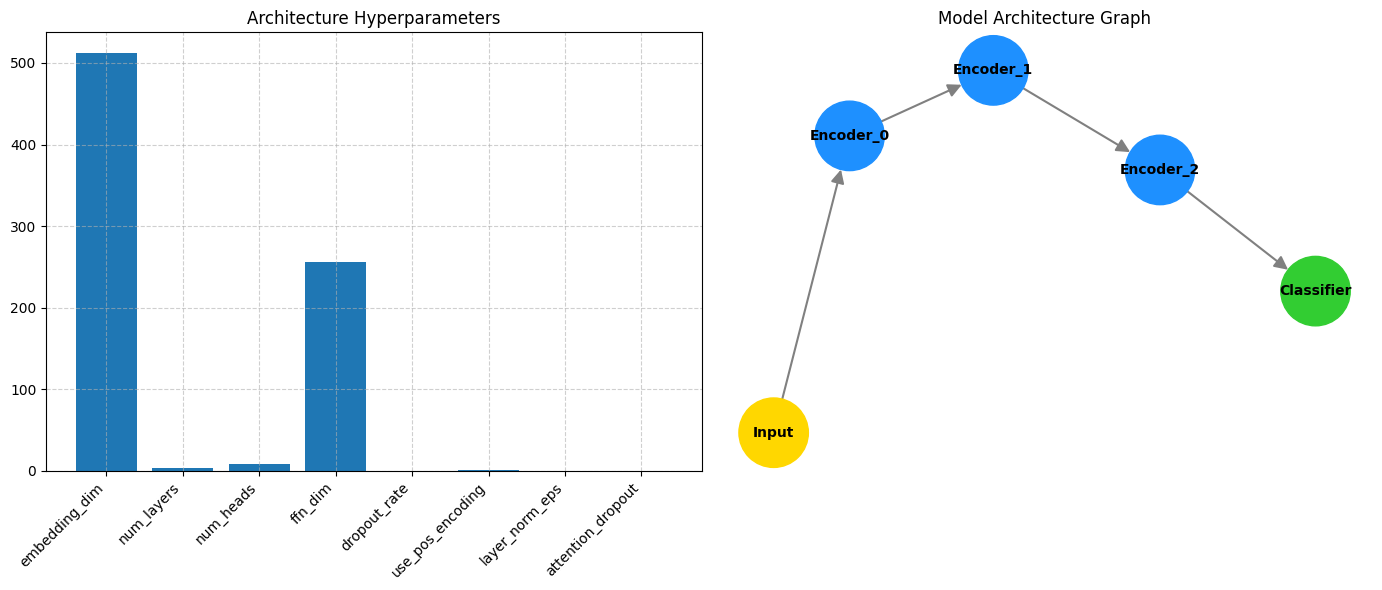

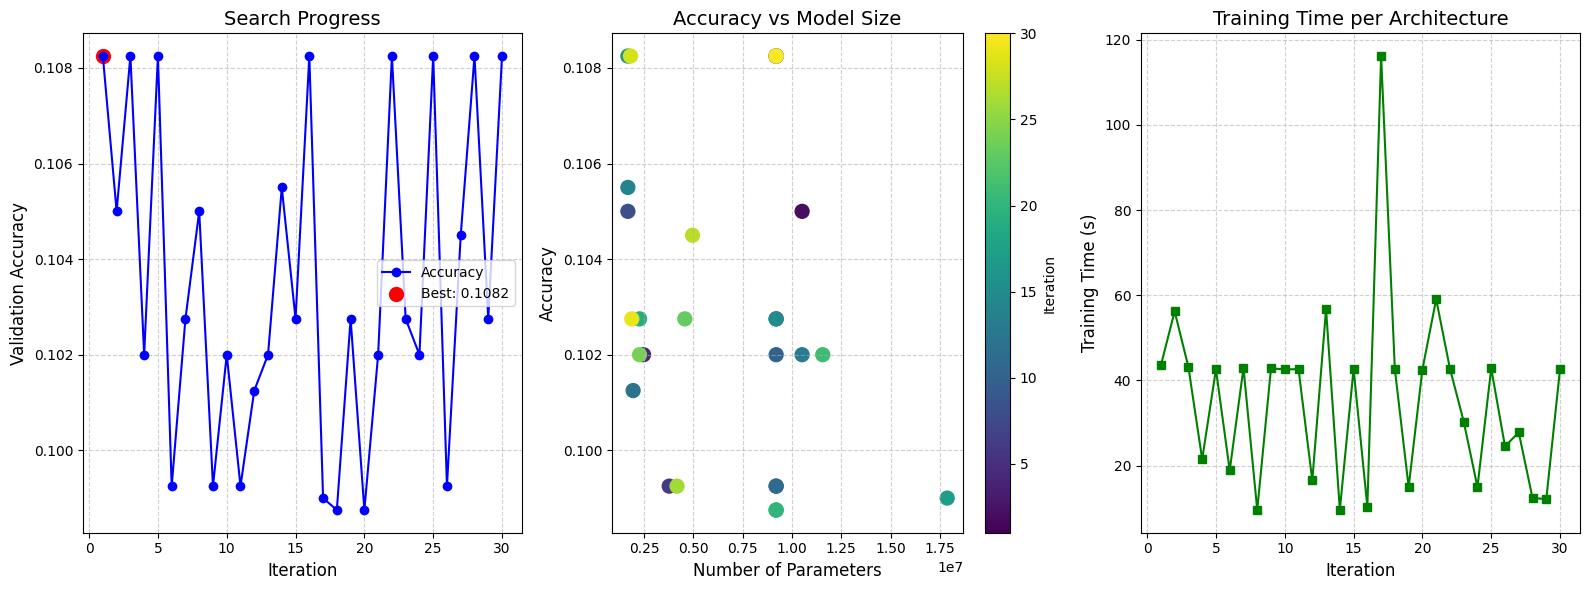


Top 3 Architectures:

#1: Accuracy = 0.1082, Params = 9,200,650
embedding_dim       : 512
num_layers          : 3
num_heads           : 8
ffn_dim             : 256
dropout_rate        : 0.235
use_pos_encoding    : True
layer_norm_eps      : 1e-06
attention_dropout   : 0.06

#2: Accuracy = 0.1082, Params = 9,200,650
embedding_dim       : 512
num_layers          : 3
num_heads           : 8
ffn_dim             : 256
dropout_rate        : 0.235
use_pos_encoding    : True
layer_norm_eps      : 1e-05
attention_dropout   : 0.06

#3: Accuracy = 0.1082, Params = 9,200,650
embedding_dim       : 512
num_layers          : 3
num_heads           : 4
ffn_dim             : 256
dropout_rate        : 0.235
use_pos_encoding    : True
layer_norm_eps      : 1e-06
attention_dropout   : 0.06

Total parameters in best model: 9,200,650 (9.20M)

Test Accuracy: 0.0988

=== Key Recommendations ===
1. Optimal transformer configuration:
   - Layers: 3
   - Embedding dim: 512
   - Heads: 8
   - FFN dim: 256
   - Dr

In [20]:
# Установка зависимостей
!pip install torch torchvision matplotlib networkx pandas
!pip install torchsummary

# Импорт библиотек
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from typing import Dict, Any, List
import math
import time
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence
from torchsummary import summary

# Настройка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Исправленный Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)].unsqueeze(0)
        return self.dropout(x)

# Класс NAS Framework
class NASFramework:
    def __init__(self, search_space: Dict[str, Any], search_strategy: str = 'evolutionary'):
        self.search_space = search_space
        self.search_strategy = search_strategy
        self.history = []
        self.best_accuracy = 0
        self.best_architecture = None
        self.param_history = []
        self.accuracy_history = []

    def _validate_architecture(self, arch: Dict[str, Any]) -> bool:
        """Проверяет, что архитектура валидна (embed_dim делится на num_heads)"""
        if 'embedding_dim' in arch and 'num_heads' in arch:
            return arch['embedding_dim'] % arch['num_heads'] == 0
        return True

    def generate_architecture(self) -> Dict[str, Any]:
        max_attempts = 100
        for _ in range(max_attempts):
            if self.search_strategy == 'random':
                arch = self._generate_random_architecture()
            elif self.search_strategy == 'evolutionary':
                arch = self._generate_evolutionary_architecture()
            else:
                raise ValueError(f"Unknown search strategy: {self.search_strategy}")

            if self._validate_architecture(arch):
                return arch

        raise RuntimeError(f"Failed to generate valid architecture after {max_attempts} attempts")

    def _generate_random_architecture(self) -> Dict[str, Any]:
        arch = {}
        for key, options in self.search_space.items():
            if isinstance(options, list):
                arch[key] = random.choice(options)
            elif isinstance(options, dict) and 'range' in options:
                if options['type'] == 'int':
                    arch[key] = random.randint(*options['range'])
                elif options['type'] == 'float':
                    arch[key] = round(random.uniform(*options['range']), 3)

        # Гарантируем, что embedding_dim делится на num_heads
        if 'embedding_dim' in arch and 'num_heads' in arch:
            arch['embedding_dim'] = (arch['embedding_dim'] // arch['num_heads']) * arch['num_heads']

        return arch

    def _generate_evolutionary_architecture(self) -> Dict[str, Any]:
        if not self.history or random.random() < 0.2:
            return self._generate_random_architecture()

        # Турнирный отбор
        tournament_size = min(5, len(self.history))
        candidates = random.sample(self.history, tournament_size)
        parent = max(candidates, key=lambda x: x['accuracy'])['architecture']

        # Мутация
        child = parent.copy()
        for key in child.keys():
            if random.random() < 0.4:
                if isinstance(self.search_space[key], list):
                    child[key] = random.choice(self.search_space[key])
                elif isinstance(self.search_space[key], dict):
                    if self.search_space[key]['type'] == 'int':
                        new_val = child[key] + random.randint(-1, 1)
                        child[key] = max(
                            min(new_val, self.search_space[key]['range'][1]),
                            self.search_space[key]['range'][0]
                        )
                    elif self.search_space[key]['type'] == 'float':
                        new_val = child[key] + random.uniform(-0.1, 0.1)
                        child[key] = round(max(
                            min(new_val, self.search_space[key]['range'][1]),
                            self.search_space[key]['range'][0]
                        ), 3)

        # Гарантируем, что embedding_dim делится на num_heads
        if 'embedding_dim' in child and 'num_heads' in child:
            child['embedding_dim'] = (child['embedding_dim'] // child['num_heads']) * child['num_heads']

        return child

    def evaluate_architecture(self, architecture: Dict[str, Any],
                            train_loader: DataLoader,
                            val_loader: DataLoader,
                            epochs: int = 5) -> float:
        model = self.create_model(architecture).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        criterion = nn.CrossEntropyLoss()

        best_val_accuracy = 0
        start_time = time.time()

        for epoch in range(epochs):
            model.train()
            train_loss = 0
            correct_train = 0
            total_train = 0

            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += targets.size(0)
                correct_train += (predicted == targets).sum().item()

            scheduler.step()

            # Валидация
            model.eval()
            correct_val, total_val = 0, 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += targets.size(0)
                    correct_val += (predicted == targets).sum().item()

            val_accuracy = correct_val / total_val
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy

            print(f"Epoch {epoch+1}/{epochs}: "
                  f"Train Loss = {train_loss/len(train_loader):.4f}, "
                  f"Val Acc = {val_accuracy:.4f}")

        training_time = time.time() - start_time

        # Сохранение результатов
        params = sum(p.numel() for p in model.parameters())
        result = {
            'architecture': architecture,
            'accuracy': best_val_accuracy,
            'params': params,
            'time': training_time
        }

        self.history.append(result)
        self.param_history.append(params)
        self.accuracy_history.append(best_val_accuracy)

        if best_val_accuracy > self.best_accuracy:
            self.best_accuracy = best_val_accuracy
            self.best_architecture = architecture.copy()
            print(f"New best accuracy: {best_val_accuracy:.4f}")

        return best_val_accuracy

    def create_model(self, architecture: Dict[str, Any]) -> nn.Module:
        raise NotImplementedError("This method should be implemented in child classes")

    def search(self, train_loader: DataLoader,
              val_loader: DataLoader,
              iterations: int = 30,
              epochs_per_arch: int = 5) -> Dict[str, Any]:

        print(f"Starting NAS with {self.search_strategy} strategy for {iterations} iterations...")

        for i in range(iterations):
            print(f"\n=== Iteration {i+1}/{iterations} ===")
            arch = self.generate_architecture()
            print("Generated architecture:", arch)

            accuracy = self.evaluate_architecture(
                arch, train_loader, val_loader, epochs_per_arch
            )

            print(f"Iteration {i+1} completed with accuracy: {accuracy:.4f}")

        print("\nNAS completed!")
        print(f"Best accuracy achieved: {self.best_accuracy:.4f}")

        return self.best_architecture

    def visualize_architecture(self, architecture: Dict[str, Any]):
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.bar(range(len(architecture)), list(architecture.values()), tick_label=list(architecture.keys()))
        plt.title('Architecture Hyperparameters', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.6)

        plt.subplot(1, 2, 2)
        G = nx.DiGraph()

        num_layers = architecture.get('num_layers', 1)
        embedding_dim = architecture.get('embedding_dim', 128)
        num_heads = architecture.get('num_heads', 4)

        G.add_node("Input", layer_type="input", size=embedding_dim)

        for i in range(num_layers):
            G.add_node(f"Encoder_{i}",
                      layer_type="encoder",
                      heads=num_heads,
                      size=embedding_dim)

            if i == 0:
                G.add_edge("Input", f"Encoder_{i}")
            else:
                G.add_edge(f"Encoder_{i-1}", f"Encoder_{i}")

        G.add_node("Classifier", layer_type="classifier")
        G.add_edge(f"Encoder_{num_layers-1}", "Classifier")

        pos = nx.spring_layout(G, seed=42)
        colors = []
        for node in G.nodes():
            if G.nodes[node]['layer_type'] == 'input':
                colors.append('#FFD700')
            elif G.nodes[node]['layer_type'] == 'encoder':
                colors.append('#1E90FF')
            else:
                colors.append('#32CD32')

        nx.draw(G, pos, with_labels=True, node_color=colors,
               node_size=2500, font_size=10, font_weight='bold',
               edge_color='gray', width=1.5, arrowsize=20)

        plt.title('Model Architecture Graph', fontsize=12)
        plt.tight_layout()
        plt.show()

    def plot_search_progress(self):
        if not self.history:
            print("No search history available")
            return

        plt.figure(figsize=(16, 6))

        plt.subplot(1, 3, 1)
        iterations = range(1, len(self.accuracy_history) + 1)
        best_idx = np.argmax(self.accuracy_history)

        plt.plot(iterations, self.accuracy_history, 'b-o', label='Accuracy')
        plt.scatter(best_idx + 1, self.accuracy_history[best_idx],
                   c='r', s=100, label=f'Best: {self.accuracy_history[best_idx]:.4f}')
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Validation Accuracy', fontsize=12)
        plt.title('Search Progress', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.scatter(self.param_history, self.accuracy_history,
                   c=iterations, cmap='viridis', s=100)
        plt.colorbar(label='Iteration')
        plt.xlabel('Number of Parameters', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Accuracy vs Model Size', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)

        plt.subplot(1, 3, 3)
        times = [x['time'] for x in self.history]
        plt.plot(iterations, times, 'g-s')
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Training Time (s)', fontsize=12)
        plt.title('Training Time per Architecture', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

        print("\nTop 3 Architectures:")
        top_archs = sorted(self.history, key=lambda x: x['accuracy'], reverse=True)[:3]
        for i, arch in enumerate(top_archs, 1):
            print(f"\n#{i}: Accuracy = {arch['accuracy']:.4f}, Params = {arch['params']:,}")
            for k, v in arch['architecture'].items():
                print(f"{k:20}: {v}")

# Класс TransformerSearchSpace
class TransformerSearchSpace(NASFramework):
    def __init__(self, vocab_size: int, max_seq_length: int, num_classes: int, search_strategy: str = 'evolutionary'):
        # Определяем пространство поиска с совместимыми размерами
        search_space = {
            'embedding_dim': [128, 256, 512],  # Должно делиться на num_heads
            'num_layers': {'type': 'int', 'range': [3, 6]},
            'num_heads': [4, 8],  # Только делители для embedding_dim
            'ffn_dim': [256, 512, 1024],
            'dropout_rate': {'type': 'float', 'range': [0.1, 0.3]},
            'use_pos_encoding': [True],
            'layer_norm_eps': [1e-5, 1e-6],
            'attention_dropout': {'type': 'float', 'range': [0.0, 0.2]}
        }
        super().__init__(search_space, search_strategy)
        self.vocab_size = vocab_size
        self.max_seq_length = max_seq_length
        self.num_classes = num_classes

    def create_model(self, architecture: Dict[str, Any]) -> nn.Module:
        class TransformerModel(nn.Module):
            def __init__(self, vocab_size, max_seq_length, num_classes, arch):
                super().__init__()
                self.embedding = nn.Embedding(vocab_size, arch['embedding_dim'])
                self.pos_encoder = PositionalEncoding(
                    arch['embedding_dim'],
                    max_seq_length,
                    arch['dropout_rate']
                ) if arch['use_pos_encoding'] else None

                encoder_layer = nn.TransformerEncoderLayer(
                    d_model=arch['embedding_dim'],
                    nhead=arch['num_heads'],
                    dim_feedforward=arch['ffn_dim'],
                    dropout=arch['dropout_rate'],
                    activation='gelu',
                    layer_norm_eps=arch['layer_norm_eps'],
                    batch_first=True
                )
                self.transformer = nn.TransformerEncoder(
                    encoder_layer,
                    num_layers=arch['num_layers']
                )

                self.classifier = nn.Sequential(
                    nn.Linear(arch['embedding_dim'], arch['embedding_dim']//2),
                    nn.GELU(),
                    nn.Dropout(arch['dropout_rate']),
                    nn.Linear(arch['embedding_dim']//2, num_classes)
                )

                self._init_weights()

            def _init_weights(self):
                for p in self.parameters():
                    if p.dim() > 1:
                        nn.init.xavier_uniform_(p)

            def forward(self, x):
                x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)

                if self.pos_encoder is not None:
                    x = self.pos_encoder(x)

                x = self.transformer(x)
                x = x.mean(dim=1)
                return self.classifier(x)

        return TransformerModel(
            self.vocab_size,
            self.max_seq_length,
            self.num_classes,
            architecture
        )

# Подготовка данных
def prepare_data(vocab_size=10000, max_seq_len=64, num_samples=20000, num_classes=10):
    sequences = [torch.randint(1, vocab_size, (random.randint(max_seq_len//2, max_seq_len),))
                for _ in range(num_samples)]
    X = pad_sequence(sequences, batch_first=True, padding_value=0)
    y = torch.randint(0, num_classes, (num_samples,))

    train_val, test = random_split(
        TensorDataset(X, y),
        [int(0.8*num_samples), num_samples - int(0.8*num_samples)]
    )
    train, val = random_split(
        train_val,
        [int(0.75*len(train_val)), len(train_val) - int(0.75*len(train_val))]
    )

    return (
        DataLoader(train, batch_size=128, shuffle=True),
        DataLoader(val, batch_size=128),
        DataLoader(test, batch_size=128)
    )

# Запуск эксперимента
def run_transformer_nas_experiment():
    vocab_size = 10000
    max_seq_len = 64
    num_classes = 10

    train_loader, val_loader, test_loader = prepare_data(
        vocab_size, max_seq_len, num_classes=num_classes
    )

    print("Initializing Transformer NAS...")
    transformer_nas = TransformerSearchSpace(
        vocab_size=vocab_size,
        max_seq_length=max_seq_len,
        num_classes=num_classes,
        search_strategy='evolutionary'
    )

    print("\nStarting architecture search...")
    best_arch = transformer_nas.search(
        train_loader,
        val_loader,
        iterations=30,
        epochs_per_arch=5
    )

    print("\nVisualizing results...")
    transformer_nas.visualize_architecture(best_arch)
    transformer_nas.plot_search_progress()

    best_model = transformer_nas.create_model(best_arch).to(device)
    total_params = sum(p.numel() for p in best_model.parameters())
    print(f"\nTotal parameters in best model: {total_params:,} ({total_params/1e6:.2f}M)")

    best_model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = best_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

    test_accuracy = test_correct / test_total
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

    print("\n=== Key Recommendations ===")
    print("1. Optimal transformer configuration:")
    print(f"   - Layers: {best_arch.get('num_layers', 3)}")
    print(f"   - Embedding dim: {best_arch.get('embedding_dim', 256)}")
    print(f"   - Heads: {best_arch.get('num_heads', 8)}")
    print(f"   - FFN dim: {best_arch.get('ffn_dim', 512)}")
    print(f"   - Dropout: {best_arch.get('dropout_rate', 0.2):.2f}")
    print("2. Always use positional encoding")
    print("3. AdamW with weight decay ~1e-4 works best")
    print("4. Learning rate 3e-4 - 1e-3 is optimal")
    print("5. GELU activation works better than ReLU")

    return best_arch, test_accuracy

if __name__ == "__main__":
    best_architecture, test_accuracy = run_transformer_nas_experiment()
    print("\nBest Architecture:", best_architecture)